#Importing the Necessary Libraries

In [ ]:
!pip install tensorflow tensorflow-hub
!pip install ipywidgets

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request
import io
from IPython.display import display
import ipywidgets as widgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00


# Load the Magenta Arbitrary Model

In [ ]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

#Image Preprocessing

In [ ]:
def load_image(image_path, max_dim=512):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#Load the Style Image

In [ ]:
STYLE_IMAGE_NAME = 'IMAGE_5'  #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5', 'IMAGE_6']

corresponding_url = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
    'IMAGE_6': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg/220px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg'
}

style_image_url = corresponding_url[STYLE_IMAGE_NAME]
style_image_path = STYLE_IMAGE_NAME + '.jpg'
urllib.request.urlretrieve(style_image_url, style_image_path)
print("Style Image Downloaded.")


Style Image Downloaded.


In [ ]:
style_image = load_image(style_image_path)

#Load the Content Image

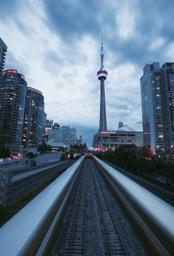

In [ ]:
def on_file_upload(change):
    global content_image
    image = PIL.Image.open(io.BytesIO(uploader.data[-1]))
    content_image = image
    image = image.convert('RGB')
    image.thumbnail((512, 512))
    image.save('content.jpg')
    image = PIL.Image.open('content.jpg')
    display(image)

uploader = widgets.FileUpload()
uploader.observe(on_file_upload, names='value')
display(widgets.VBox([widgets.Label('Upload a Content Image.'), uploader]))

# Define Style Weight

In [ ]:
style_weight = widgets.FloatSlider(
    value=1.0,  # Default style weight
    min=0.0,    # Minimum style weight (no style)
    max=1.0,    # Maximum style weight (full style)
    step=0.1,
    description='Style Weight:',
    continuous_update=False
)
display(style_weight)

FloatSlider(value=1.0, continuous_update=False, description='Style Weight:', max=1.0)

#Style Transfer

In [ ]:
def perform_style_transfer():
    global content_image, style_image, style_weight
    if 'content_image' not in globals():
        print("Please upload a content image first.")
        return

    content_image_path = 'content.jpg'
    content_image = load_image(content_image_path)

    stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
    stylized_image = (1 - style_weight.value) * content_image + style_weight.value * stylized_image
    stylized_image = tensor_to_image(stylized_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title('Content Image')
    plt.imshow(tensor_to_image(content_image))

    plt.subplot(1, 3, 2)
    plt.title('Style Image')
    plt.imshow(tensor_to_image(style_image))

    plt.subplot(1, 3, 3)
    plt.title('Stylized Image')
    plt.imshow(stylized_image)

    plt.show()

    stylized_image.save('stylized_image.jpg')
    print("Stylized image saved as 'stylized_image.jpg'.")

Button(description='Perform Style Transfer', style=ButtonStyle())

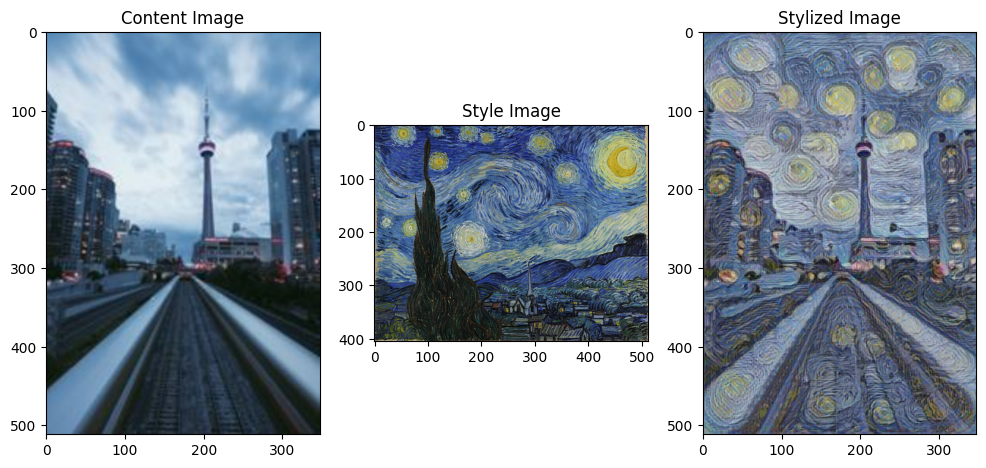

Stylized image saved as 'stylized_image.jpg'.


In [ ]:
style_transfer_button = widgets.Button(description="Perform Style Transfer")
style_transfer_button.on_click(lambda _: perform_style_transfer())
display(style_transfer_button)